# Self-supervised learning in 3D images

Use the context encoder-style method as described in [1]

    [1] D. Pathak et al. "Context encoders: Feature learning by inpainting."
        CVPR. 2016.

## Setup notebook

In [1]:
from typing import Callable, List, Optional, Tuple, Union

from glob import glob
import math
import os
import random
import sys

gpu_id = 1
os.environ["CUDA_VISIBLE_DEVICES"] = f'{gpu_id}'

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision

from selfsupervised3d import *

 Support in-notebook plotting

In [2]:
%matplotlib inline

Report versions

In [3]:
print('numpy version: {}'.format(np.__version__))
from matplotlib import __version__ as mplver
print('matplotlib version: {}'.format(mplver))
print(f'pytorch version: {torch.__version__}')
print(f'torchvision version: {torchvision.__version__}')

numpy version: 1.17.2
matplotlib version: 3.1.1
pytorch version: 1.5.0
torchvision version: 0.6.0a0+82fd1c8


In [4]:
pv = sys.version_info
print('python version: {}.{}.{}'.format(pv.major, pv.minor, pv.micro))

python version: 3.7.7


Reload packages where content for package development

In [5]:
%load_ext autoreload
%autoreload 2

Check GPU(s)

In [6]:
!nvidia-smi

Wed May  6 20:29:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 430.40       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla M40 24GB      Off  | 00000000:02:00.0 Off |                    0 |
| N/A   55C    P0   146W / 250W |  11185MiB / 22945MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla M40 24GB      Off  | 00000000:03:00.0 Off |                    0 |
| N/A   40C    P0    65W / 250W |     11MiB / 22945MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [7]:
assert torch.cuda.is_available()
device = torch.device('cuda')
torch.backends.cudnn.benchmark = True

Set seeds for better reproducibility. See [this note](https://pytorch.org/docs/stable/notes/faq.html#my-data-loader-workers-return-identical-random-numbers) before using multiprocessing.

In [8]:
seed = 1336
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## Setup training and validation data

Get the location of the training (and validation) data

In [9]:
train_dir = '/iacl/pg20/jacobr/ixi/subsets/hh/'
t1_dir = os.path.join(train_dir, 't1')
t2_dir = os.path.join(train_dir, 't2')

In [10]:
t1_fns = glob(os.path.join(t1_dir, '*.nii*'))
t2_fns = glob(os.path.join(t2_dir, '*.nii*'))
assert len(t1_fns) == len(t2_fns) and len(t1_fns) != 0

## Look at example training dataset

Look at an axial view of the source T1-weighted (T1-w) and target T2-weighted (T2-w) images.

In [11]:
def imshow(x, ax, title, n_rot=3):
    ax.imshow(np.rot90(x,n_rot), aspect='equal', cmap='gray')
    ax.set_title(title,fontsize=22)
    ax.axis('off')

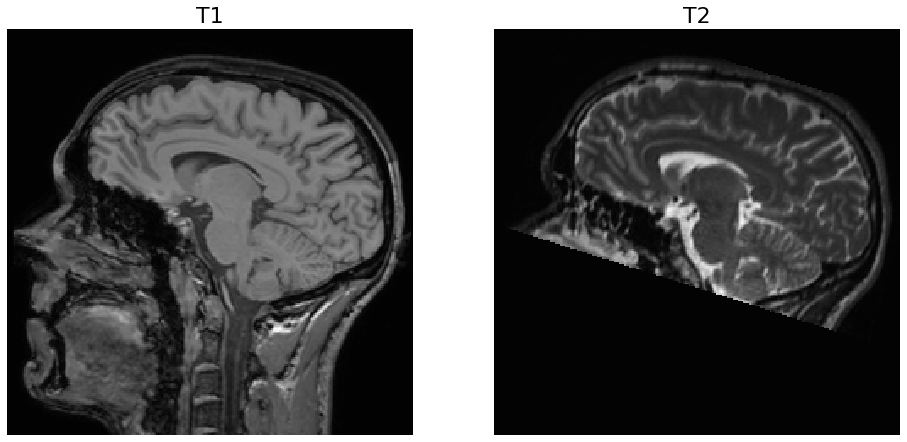

In [12]:
j = 100
t1_ex, t2_ex = nib.load(t1_fns[0]).get_data(), nib.load(t2_fns[0]).get_data()
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,9))
imshow(t1_ex[...,j], ax1, 'T1', 1)
imshow(t2_ex[...,j], ax2, 'T2', 1)

In [13]:
mask = create_multiblock_mask(t1_ex > t1_ex.mean(), 15, 20)

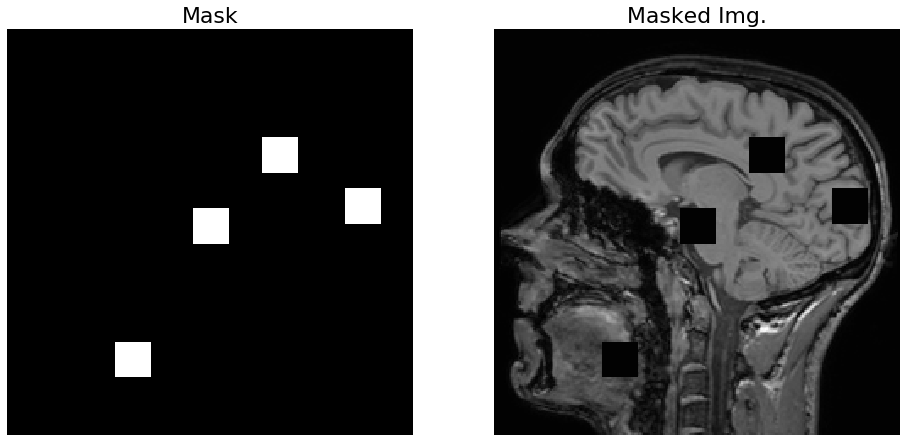

In [14]:
j = 100
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,9))
imshow(mask[...,j], ax1, 'Mask', 1)
imshow(t1_ex[...,j] * (1-mask[...,j]), ax2, 'Masked Img.', 1)

## Setup training

Hyperparameters, optimizers, logging, etc.

In [15]:
data_dirs = [t1_dir]

In [16]:
# system setup
load_model = False

# logging setup
log_rate = 1  # print losses every log_rate epochs
version = 'context_v1'  # naming scheme of model to load
save_rate = 5   # save models every save_rate epochs

# dataset params
block_size = 20
n_blocks = 15

# model, optimizer, loss, and training parameters
valid_split = 0.1
batch_size = 1
n_jobs = 0
n_epochs = 25
input_channels = len(data_dirs)
use_adam = True
opt_kwargs = dict(lr=1e-3, betas=(0.9,0.99), weight_decay=1e-6) if use_adam else \
             dict(lr=5e-3, momentum=0.9)
use_scheduler = True
scheduler_kwargs = dict(step_size=5, gamma=0.5)

In [17]:
def init_fn(worker_id):
    random.seed((torch.initial_seed() + worker_id) % (2**32))
    np.random.seed((torch.initial_seed() + worker_id) % (2**32))

In [18]:
# setup training and validation dataloaders
dataset = ContextDataset(data_dirs, n_blocks=n_blocks, size=block_size)
num_train = len(dataset)
indices = list(range(num_train))
split = int(valid_split * num_train)
valid_idx = np.random.choice(indices, size=split, replace=False)
train_idx = list(set(indices) - set(valid_idx))
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, 
                          worker_init_fn=init_fn, num_workers=n_jobs,
                          pin_memory=True, collate_fn=context_collate)
valid_loader = DataLoader(dataset, sampler=valid_sampler, batch_size=batch_size, 
                          worker_init_fn=init_fn, num_workers=n_jobs,
                          pin_memory=True, collate_fn=context_collate)

In [19]:
print(f'Number of training images: {num_train-split}')
print(f'Number of validation images: {split}')

Number of training images: 121
Number of validation images: 13


In [20]:
recon_model = FrankUNet(ic=input_channels, nc=16)
discriminator = PatchDiscriminator(1, 36) 

In [21]:
def num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [22]:
print(f'Number of trainable parameters in reconstruction model: {num_params(recon_model)}')
print(f'Number of trainable parameters in discriminator: {num_params(discriminator)}')

Number of trainable parameters in reconstruction model: 3477729
Number of trainable parameters in discriminator: 3505429


In [23]:
if load_model: 
    recon_model.load_state_dict(torch.load(f'recon_model_{version}.pth'))
    discriminator.load_state_dict(torch.load(f'discriminator_{version}.pth'))

In [24]:
recon_model.to(device)
discriminator.to(device)
optim_cls = torch.optim.AdamW if use_adam else torch.optim.SGD
optG = optim_cls(recon_model.parameters(), **opt_kwargs)
optD = optim_cls(discriminator.parameters(), **opt_kwargs)
criterion = InpaintLoss()
if use_scheduler:
    recon_scheduler = torch.optim.lr_scheduler.StepLR(optG, **scheduler_kwargs)
    disc_scheduler = torch.optim.lr_scheduler.StepLR(optD, **scheduler_kwargs)

## Train model

In [25]:
train_losses, valid_losses = [], []
n_batches = len(train_loader)

In [26]:
for t in range(1, n_epochs + 1):
    # training
    t_losses = []
    recon_model.train()
    discriminator.train()
    for i, (src, tgt, mask) in enumerate(train_loader):
        src, tgt, mask = src.to(device), tgt.to(device), mask.to(device)
        optG.zero_grad()
        optD.zero_grad()
        recon = recon_model(src)
        disc_real = discriminator(tgt)
        disc_fake = discriminator(recon)
        loss = criterion(recon, tgt, mask, disc_real, disc_fake)
        t_losses.append(loss.item())
        loss.backward()
        optG.step()
        optD.step()
    train_losses.append(t_losses)

    # validation
    v_losses = []
    recon_model.eval()
    discriminator.eval()
    with torch.no_grad():
        for i, (src, tgt, mask) in enumerate(valid_loader):
            src, tgt, mask = src.to(device), tgt.to(device), mask.to(device)
            recon = recon_model(src)
            disc_real = discriminator(tgt)
            disc_fake = discriminator(recon)
            loss = criterion(recon, tgt, mask, disc_real, disc_fake)
            v_losses.append(loss.item())
        valid_losses.append(v_losses)

    # log, step scheduler, and save results from epoch
    if not np.all(np.isfinite(t_losses)): 
        raise RuntimeError('NaN or Inf in training loss, cannot recover. Exiting.')
    if t % log_rate == 0:
        log = (f'Epoch: {t} - TL: {np.mean(t_losses):.2e}, VL: {np.mean(v_losses):.2e}')
        print(log)
    if use_scheduler:
        recon_scheduler.step()
        disc_scheduler.step()
    if t % save_rate == 0:
        torch.save(recon_model.state_dict(), f'recon_model_{version}_{t}.pth')
        torch.save(discriminator.state_dict(), f'discriminator_{version}_{t}.pth')

Epoch: 1 - TL: 1.92e-01, VL: 1.21e-01
Epoch: 2 - TL: 1.20e-01, VL: 1.27e-01
Epoch: 3 - TL: 1.13e-01, VL: 1.02e-01
Epoch: 4 - TL: 1.11e-01, VL: 1.25e-01
Epoch: 5 - TL: 1.02e-01, VL: 1.17e-01
Epoch: 6 - TL: 9.35e-02, VL: 8.99e-02
Epoch: 7 - TL: 8.97e-02, VL: 8.68e-02
Epoch: 8 - TL: 8.70e-02, VL: 8.84e-02
Epoch: 9 - TL: 8.60e-02, VL: 8.71e-02
Epoch: 10 - TL: 8.29e-02, VL: 8.76e-02
Epoch: 11 - TL: 7.94e-02, VL: 7.65e-02
Epoch: 12 - TL: 7.80e-02, VL: 7.94e-02
Epoch: 13 - TL: 7.84e-02, VL: 1.05e-01
Epoch: 14 - TL: 7.76e-02, VL: 8.06e-02
Epoch: 15 - TL: 7.64e-02, VL: 7.78e-02
Epoch: 16 - TL: 7.49e-02, VL: 7.31e-02
Epoch: 17 - TL: 7.42e-02, VL: 7.55e-02
Epoch: 18 - TL: 7.38e-02, VL: 7.95e-02
Epoch: 19 - TL: 7.42e-02, VL: 7.20e-02
Epoch: 20 - TL: 7.28e-02, VL: 7.70e-02
Epoch: 21 - TL: 7.20e-02, VL: 7.10e-02
Epoch: 22 - TL: 7.20e-02, VL: 7.18e-02
Epoch: 23 - TL: 7.25e-02, VL: 7.35e-02
Epoch: 24 - TL: 7.18e-02, VL: 7.07e-02
Epoch: 25 - TL: 7.12e-02, VL: 7.24e-02


In [28]:
save_model = True
if save_model:
    torch.save(recon_model.state_dict(), f'recon_model_{version}.pth')
    torch.save(discriminator.state_dict(), f'discriminator_{version}.pth')

## Analyze training

In [29]:
def tidy_losses(train, valid):
    out = {'epoch': [], 'type': [], 'value': [], 'phase': []}
    for i, (tl,vl) in enumerate(zip(train,valid),1):
        for tli in tl:
            out['epoch'].append(i)
            out['type'].append('loss')
            out['value'].append(tli)
            out['phase'].append('train')
        for vli in vl:
            out['epoch'].append(i)
            out['type'].append('loss')
            out['value'].append(vli)
            out['phase'].append('valid')
    return pd.DataFrame(out)

In [30]:
losses = tidy_losses(train_losses, valid_losses)

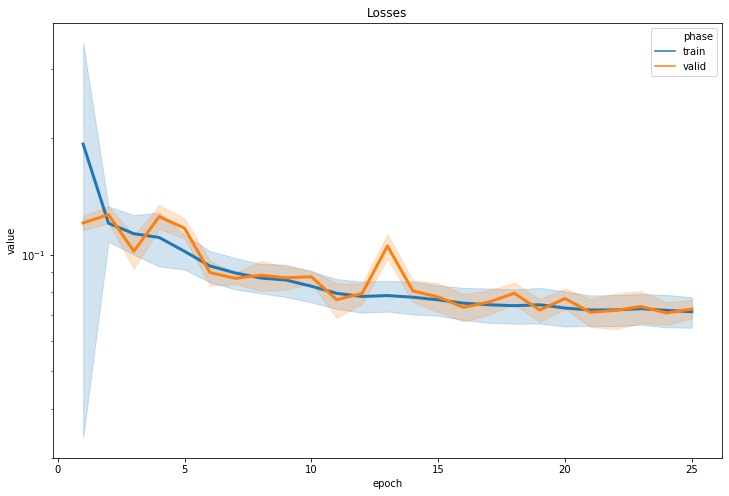

In [31]:
f, ax1 = plt.subplots(1,1,figsize=(12, 8),sharey=True)
sns.lineplot(x='epoch',y='value',hue='phase',data=losses,ci='sd',ax=ax1,lw=3);
ax1.set_yscale('log');
ax1.set_title('Losses');

In [32]:
save_losses = False
if save_losses:
    f.savefig(f'losses_{version}.pdf')
    losses.to_csv(f'losses_{version}.csv')

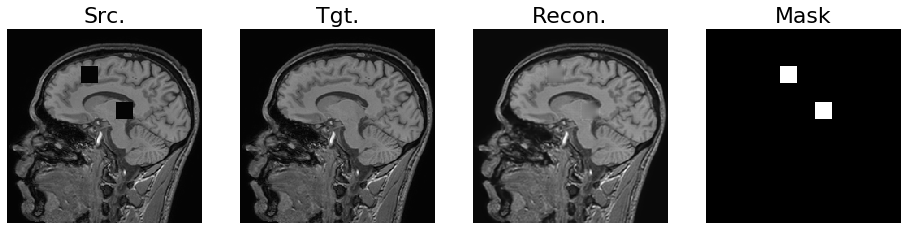

In [33]:
j = 100
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(16,9))
try:
    src   = src.squeeze().cpu().detach().numpy()
    tgt   = tgt.squeeze().cpu().detach().numpy()
    recon = recon.squeeze().cpu().detach().numpy()
    mask  = mask.squeeze().cpu().detach().numpy()
except AttributeError:
    pass
imshow(src[...,j], ax1, 'Src.', 1)
imshow(tgt[...,j], ax2, 'Tgt.', 1)
imshow(recon[...,j], ax3, 'Recon.', 1)
imshow(mask[...,j], ax4, 'Mask', 1)

The hyperparameters above can probably modified to improve this result. Also, it would be better to use a brain mask as an additional input to the `ContextDataset` (see the `mask_dir` keyword argument); a brain mask would keep the random blocks inside the brain which would force the network to learn only how to fill in brain versus neck and other tissue.